## Recipe-2.The Tokenizers Toolkit:Encoding, decoding, padding, truncation, attention masks

In [ ]:
pip install transformers torch sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# --- Recipe: The Tokenizer's Toolkit ---
# Goal: Demonstrate core tokenizer functionalities: encoding, decoding, special tokens, padding, truncation.
# Library: Hugging Face Transformers
# Note: Ensure you have run `pip install transformers torch sentencepiece` (SentencePiece needed for Gemma/Mistral).

from transformers import AutoTokenizer
from huggingface_hub import login

In [ ]:
from huggingface_hub import HfApi

api = HfApi()
whoami = api.whoami(token="hf_xxxxxxxxxxxxxx")
print(whoami)
login("hf_xxxxxxxxxxxxxxxxx")

{'type': 'user', 'id': '65feba1b57cc48d9d30d11cf', 'name': 'kalpasubbaiah', 'fullname': 'Kalpa Subbaiah', 'email': 'kalpa.subbaiah@gmail.com', 'emailVerified': True, 'canPay': False, 'periodEnd': None, 'isPro': False, 'avatarUrl': '/avatars/319094e0eb55ce89334d7bd3685ceeb0.svg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'hugging_face_token_read', 'role': 'read', 'createdAt': '2025-04-22T09:03:46.223Z'}}}


In [ ]:
# --- Configuration ---
# Choose a model ID whose tokenizer you want to explore.
# Using Gemma here as SentencePiece tokenizers are common.
model_id = "google/gemma-2b-it"
# Other options: "mistralai/Mistral-7B-v0.1", "bert-base-uncased" (WordPiece), "gpt2" (BPE)

In [ ]:
print(f"Loading tokenizer for model: {model_id}")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    print("Tokenizer loaded successfully.")
    print(f"Tokenizer class: {tokenizer.__class__}")
    print(f"Vocabulary size: {tokenizer.vocab_size}")
    print(f"Special tokens: {tokenizer.special_tokens_map}")
    print(f"PAD token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
    print(f"UNK token: '{tokenizer.unk_token}', ID: {tokenizer.unk_token_id}")
    print(f"BOS token: '{tokenizer.bos_token}', ID: {tokenizer.bos_token_id}") # Beginning of Sequence
    print(f"EOS token: '{tokenizer.eos_token}', ID: {tokenizer.eos_token_id}") # End of Sequence
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    exit()

Loading tokenizer for model: google/gemma-2b-it
Tokenizer loaded successfully.
Tokenizer class: <class 'transformers.models.gemma.tokenization_gemma_fast.GemmaTokenizerFast'>
Vocabulary size: 256000
Special tokens: {'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}
PAD token: '<pad>', ID: 0
UNK token: '<unk>', ID: 3
BOS token: '<bos>', ID: 2
EOS token: '<eos>', ID: 1


In [ ]:
# --- Basic Encoding & Decoding ---
text = "LLMs need careful data preparation."
print(f"\nOriginal text: '{text}'")

# Encode: Text -> Token IDs
# `encode` is a simple method, often `tokenizer()` or `tokenizer.encode_plus()` offer more options.
encoded_ids = tokenizer.encode(text)
print(f"Encoded IDs: {encoded_ids}")

# Decode: Token IDs -> Text
decoded_text = tokenizer.decode(encoded_ids)
print(f"Decoded text: '{decoded_text}'")


Original text: 'LLMs need careful data preparation.'
Encoded IDs: [2, 1650, 14816, 1476, 15136, 1423, 12988, 235265]
Decoded text: '<bos>LLMs need careful data preparation.'


In [ ]:
# --- Using the Tokenizer Call Method (Recommended) ---
# The __call__ method handles multiple inputs, padding, truncation, and returns attention masks.
texts = [
    "This is a short sequence.",
    "This sequence is considerably longer and will likely exceed the truncation length.",
    "A third sequence."
]
print(f"\nBatch of texts:\n{texts}")

# Tokenize the batch with padding and truncation
# - padding='longest': Pad sequences to the length of the longest sequence in the batch.
# - truncation=True: Truncate sequences longer than the model's max length (or specified max_length).
# - max_length: Explicitly set a maximum length (optional, defaults often to model's capability).
# - return_tensors='pt': Return results as PyTorch tensors (use 'tf' for TensorFlow, 'np' for NumPy).
tokenized_output = tokenizer(
    texts,
    padding='longest', # Pad to longest sequence in batch
    truncation=True,   # Truncate sequences longer than max_length
    max_length=15,     # Set an example max length
    return_tensors='pt' # Return PyTorch tensors
)

print("\nTokenized Output (Batch):")
print(f"- Input IDs:\n{tokenized_output['input_ids']}")
print(f"- Attention Mask:\n{tokenized_output['attention_mask']}") # 1 for real tokens, 0 for PAD tokens



Batch of texts:
['This is a short sequence.', 'This sequence is considerably longer and will likely exceed the truncation length.', 'A third sequence.']

Tokenized Output (Batch):
- Input IDs:
tensor([[     0,      0,      0,      0,      0,      0,      0,      2,   1596,
            603,    476,   3309,  10629, 235265],
        [     2,   1596,  10629,    603,  27681,   5543,    578,    877,   5476,
          15542,    573, 190604,   4191, 235265],
        [     0,      0,      0,      0,      0,      0,      0,      0,      0,
              2, 235280,   4906,  10629, 235265]])
- Attention Mask:
tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]])


In [ ]:
# --- Inspecting Padding and Attention Mask ---
print("\nInspecting the first sequence's padding:")
first_seq_ids = tokenized_output['input_ids'][0]
first_seq_mask = tokenized_output['attention_mask'][0]
print(f"- Padded IDs: {first_seq_ids.tolist()}") # .tolist() for cleaner printing
print(f"- Corresponding Mask: {first_seq_mask.tolist()}")
# Decode manually to see the padding token (if PAD token ID is known)
# Note: decode skips special tokens by default unless skip_special_tokens=False
print(f"- Decoded (incl. PAD if visible): '{tokenizer.decode(first_seq_ids, skip_special_tokens=False)}'")
print(f"- Decoded (default, skips PAD): '{tokenizer.decode(first_seq_ids, skip_special_tokens=True)}'")



Inspecting the first sequence's padding:
- Padded IDs: [0, 0, 0, 0, 0, 0, 0, 2, 1596, 603, 476, 3309, 10629, 235265]
- Corresponding Mask: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
- Decoded (incl. PAD if visible): '<pad><pad><pad><pad><pad><pad><pad><bos>This is a short sequence.'
- Decoded (default, skips PAD): 'This is a short sequence.'


In [ ]:
# --- Inspecting Truncation ---
print("\nInspecting the second sequence's truncation:")
second_seq_ids = tokenized_output['input_ids'][1]
print(f"- Truncated IDs (length {len(second_seq_ids)}): {second_seq_ids.tolist()}")
print(f"- Decoded truncated text: '{tokenizer.decode(second_seq_ids)}'")
# Compare length to max_length defined above (15)

# --- End of Recipe ---


Inspecting the second sequence's truncation:
- Truncated IDs (length 14): [2, 1596, 10629, 603, 27681, 5543, 578, 877, 5476, 15542, 573, 190604, 4191, 235265]
- Decoded truncated text: '<bos>This sequence is considerably longer and will likely exceed the truncation length.'


## Recipe-1: Loading Custom Ingredients (Local Files)

In [ ]:
pip install datasets pandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


DATASETS

In [ ]:
# --- Recipe: Loading Custom Ingredients (Local Files) ---
# Goal: Load data from local CSV and JSON Lines files into a Hugging Face Dataset object.
# Library: Hugging Face Datasets
# Note: Ensure you have run `pip install datasets pandas`

import os
from datasets import load_dataset
import json
import csv

# --- 1. Create Dummy Data Files ---
# Create a temporary directory for our data
data_dir = "./temp_custom_data"
os.makedirs(data_dir, exist_ok=True)

# Create a dummy CSV file
csv_file_path = os.path.join(data_dir, "recipes.csv")
csv_data = [
    {"id": 1, "dish_name": "Spaghetti Carbonara", "prep_time_mins": 15, "ingredients": "Pasta, Eggs, Pancetta, Cheese"},
    {"id": 2, "dish_name": "Chicken Curry", "prep_time_mins": 20, "ingredients": "Chicken, Onion, Tomato, Spices"},
    {"id": 3, "dish_name": "Vegetable Stir-fry", "prep_time_mins": 10, "ingredients": "Broccoli, Peppers, Soy Sauce, Noodles"}
]
print(f"Creating dummy CSV file: {csv_file_path}")
with open(csv_file_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=csv_data[0].keys())
    writer.writeheader()
    writer.writerows(csv_data)

# Create a dummy JSON Lines file (.jsonl)
jsonl_file_path = os.path.join(data_dir, "instructions.jsonl")
jsonl_data = [
    {"instruction": "Make a cup of tea.", "input": "", "output": "Boil water, add tea bag to cup, pour water, steep, remove bag."},
    {"instruction": "Explain photosynthesis.", "input": "", "output": "Photosynthesis is the process plants use to convert light energy into chemical energy."},
    {"instruction": "Translate to French.", "input": "Hello world", "output": "Bonjour le monde"}
]
print(f"Creating dummy JSON Lines file: {jsonl_file_path}")
with open(jsonl_file_path, 'w', encoding='utf-8') as f:
    for line in jsonl_data:
        f.write(json.dumps(line) + '\n')

Creating dummy CSV file: ./temp_custom_data/recipes.csv
Creating dummy JSON Lines file: ./temp_custom_data/instructions.jsonl


In [ ]:
# --- 2. Load Data using load_dataset ---

print("\n--- Loading CSV Data ---")
try:
    # For CSV, specify 'csv' type and the path to the file(s)
    # `data_files` can be a single path, a list of paths, or a dict for splits {'train': 'path1', 'test': 'path2'}
    csv_dataset = load_dataset('csv', data_files=csv_file_path)
    print("CSV dataset loaded successfully:")
    print(csv_dataset)
    # Note: The default split name is 'train' when loading single files
    print("\nAccessing the 'train' split:")
    print(csv_dataset['train'])
    print("\nFirst example from CSV dataset:")
    print(csv_dataset['train'][0])
    print("\nFeatures (columns and types):")
    print(csv_dataset['train'].features)

except Exception as e:
    print(f"Error loading CSV dataset: {e}")


print("\n--- Loading JSON Lines Data ---")
try:
    # For JSON Lines, specify 'json' type
    jsonl_dataset = load_dataset('json', data_files=jsonl_file_path)
    print("JSON Lines dataset loaded successfully:")
    print(jsonl_dataset)
    print("\nFirst example from JSON Lines dataset:")
    print(jsonl_dataset['train'][0])
    print("\nFeatures (columns and types):")
    print(jsonl_dataset['train'].features)

except Exception as e:
    print(f"Error loading JSON Lines dataset: {e}")


--- Loading CSV Data ---


Generating train split: 0 examples [00:00, ? examples/s]

CSV dataset loaded successfully:
DatasetDict({
    train: Dataset({
        features: ['id', 'dish_name', 'prep_time_mins', 'ingredients'],
        num_rows: 3
    })
})

Accessing the 'train' split:
Dataset({
    features: ['id', 'dish_name', 'prep_time_mins', 'ingredients'],
    num_rows: 3
})

First example from CSV dataset:
{'id': 1, 'dish_name': 'Spaghetti Carbonara', 'prep_time_mins': 15, 'ingredients': 'Pasta, Eggs, Pancetta, Cheese'}

Features (columns and types):
{'id': Value(dtype='int64', id=None), 'dish_name': Value(dtype='string', id=None), 'prep_time_mins': Value(dtype='int64', id=None), 'ingredients': Value(dtype='string', id=None)}

--- Loading JSON Lines Data ---


Generating train split: 0 examples [00:00, ? examples/s]

JSON Lines dataset loaded successfully:
DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 3
    })
})

First example from JSON Lines dataset:
{'instruction': 'Make a cup of tea.', 'input': '', 'output': 'Boil water, add tea bag to cup, pour water, steep, remove bag.'}

Features (columns and types):
{'instruction': Value(dtype='string', id=None), 'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None)}


In [ ]:
# --- 3. Loading Multiple Files or Splits ---
# If you have separate files for train/validation/test:
# multi_file_dataset = load_dataset('csv', data_files={
#     'train': ['path/to/train1.csv', 'path/to/train2.csv'],
#     'validation': 'path/to/validation.csv',
#     'test': 'path/to/test.csv'
# })
# print("\nExample of loading multiple files/splits (structure):")
# print(multi_file_dataset) # This would show train, validation, test splits if paths were real

# --- Cleanup Dummy Data (Optional) ---
# import shutil
# print(f"\nCleaning up temporary data directory: {data_dir}")
# shutil.rmtree(data_dir)

# --- End of Recipe ---


## Recipe-4: Handling Massive Datasets with Streaming


In [ ]:
# --- Recipe: Handling Massive Datasets with Streaming ---
# Goal: Load and iterate over a large dataset from the Hub without downloading it all.
# Library: Hugging Face Datasets
# Note: Uses OSCAR dataset as an example - it's very large.

from datasets import load_dataset
from itertools import islice # Used to take only a few samples for demonstration

# --- Configuration ---
# OSCAR is a huge multilingual corpus. We'll use a subset.
# Choose a configuration, e.g., 'unshuffled_deduplicated_en' for English.
# Check the dataset card on Hugging Face Hub for available configurations.
dataset_name = "oscar"
config_name = "unshuffled_deduplicated_en" # English subset
num_samples_to_show = 5 # How many samples to print

In [ ]:
# --- Option 1: Standard Loading (Downloads Everything - DO NOT RUN FOR VERY LARGE DATASETS unless intended) ---
# print("\n--- Attempting Standard Load (Downloads dataset - potentially very large!) ---")
# try:
#     # This will download and cache the dataset locally (can take hours/days and lots of disk space for OSCAR)
#     # standard_dataset = load_dataset(dataset_name, config_name)
#     # print("Standard dataset loaded (likely from cache if run before).")
#     # print(standard_dataset['train'])
#     # print(f"First example (standard): {standard_dataset['train'][0]}")
#     print("Standard load example commented out to prevent accidental large download.")
# except Exception as e:
#     print(f"Error during standard load: {e}")


In [ ]:
# --- Option 2: Streaming Mode (Recommended for Large Datasets) ---
print(f"\n--- Loading Dataset in Streaming Mode: {dataset_name} ({config_name}) ---")
try:
    # Set streaming=True
    # This creates an IterableDataset that yields samples one by one.
    # No download of the full dataset happens upfront.
    streamed_dataset = load_dataset(dataset_name, config_name, streaming=True)

    print("Streamed dataset object created successfully:")
    # Note: IterableDatasets don't have a defined length `len()` or direct indexing `[i]`
    print(streamed_dataset)
    print(f"\nIterating through the first {num_samples_to_show} samples (streaming):")

    # Get an iterator for the 'train' split
    dataset_iterator = iter(streamed_dataset['train'])

    # Use itertools.islice to take just the first few samples without iterating the whole dataset
    for i, example in enumerate(islice(dataset_iterator, num_samples_to_show)):
        print(f"\n--- Sample {i+1} ---")
        # Print only a snippet of the text as it can be very long
        text_snippet = example.get('text', 'N/A')[:200] + "..." # Get first 200 chars
        print(f"ID: {example.get('id', 'N/A')}")
        print(f"Text Snippet: {text_snippet}")
        # You can access other features if available, e.g., example.get('meta')

    print(f"\nSuccessfully streamed and displayed first {num_samples_to_show} samples.")

    # You can apply transformations like .map() or .filter() to streamed datasets too!
    # They will be applied on-the-fly as you iterate.
    # Example: streamed_dataset['train'].map(lambda example: {'len': len(example['text'])})

except Exception as e:
    print(f"Error during streaming load or iteration: {e}")
    print("Check dataset name, config name, and internet connection.")

# --- End of Recipe ---



--- Loading Dataset in Streaming Mode: oscar (unshuffled_deduplicated_en) ---
Streamed dataset object created successfully:
IterableDatasetDict({
    train: IterableDataset({
        features: ['id', 'text'],
        num_shards: 670
    })
})

Iterating through the first 5 samples (streaming):

--- Sample 1 ---
ID: 0
Text Snippet: Mtendere Village was inspired by the vision of Chief Napoleon Dzombe, which he shared with John Blanchard during his first visit to Malawi. Chief Napoleon conveyed the desperate need for a program to ...

--- Sample 2 ---
ID: 1
Text Snippet: Lily James cannot fight the music. In the title role of 2015’s handsome Cinderella rework, her beautiful singing served as a plot point, attracting a suitor to her like a sailor drawn in by a siren’s ...

--- Sample 3 ---
ID: 2
Text Snippet: "I'd love to help kickstart continued development! And 0 EUR/month really does make fiscal sense too... maybe I'll even get a shirt?" (there will be limited edition shirts for two an

##Recipe-3: Measuring Your Ingredients (Visualizing Token Lengths)

In [ ]:
# --- Recipe: Measuring Your Ingredients (Visualizing Token Lengths) ---
# Goal: Tokenize a dataset sample and plot a histogram of sequence lengths.
# Libraries: Hugging Face Datasets, Transformers, Matplotlib
# Note: Ensure you have run `pip install datasets transformers torch matplotlib sentencepiece`

import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np

# --- Configuration ---
dataset_name = "imdb" # Standard sentiment analysis dataset (text reviews)
split = "train" # Choose split (e.g., 'train', 'test')
text_column = "text" # Column containing the text data in the dataset
# Choose a tokenizer consistent with models you might use
tokenizer_id = "distilbert-base-uncased" # Smaller BERT-like model tokenizer
num_samples_for_analysis = 1000 # Analyze a subset for efficiency

print(f"Loading dataset: {dataset_name} (split: {split})")
try:
    # Load a subset using slicing for efficiency if dataset is large
    # dataset = load_dataset(dataset_name, split=f"{split}[:{num_samples_for_analysis}]")
    # Or load normally and select later if small enough
    full_dataset = load_dataset(dataset_name)
    dataset = full_dataset[split].select(range(min(num_samples_for_analysis, len(full_dataset[split]))))
    print(f"Loaded {len(dataset)} samples for analysis.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

print(f"\nLoading tokenizer: {tokenizer_id}")
try:
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)
    print("Tokenizer loaded.")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    exit()

Loading dataset: imdb (split: train)
Loaded 1000 samples for analysis.

Loading tokenizer: distilbert-base-uncased
Tokenizer loaded.


In [ ]:
# --- Tokenize the Dataset ---
# Define a function to tokenize examples and get lengths
def tokenize_and_get_length(batch):
    tokenized = tokenizer(batch[text_column], truncation=False, padding=False, max_length=512)
    lengths = [len(input_ids) for input_ids in tokenized["input_ids"]]
    return {"token_length": lengths}

print("\nTokenizing dataset samples to calculate lengths...")
try:
    # Use .map() to apply the function efficiently
    # batched=True processes multiple examples at once
    dataset_with_lengths = dataset.map(tokenize_and_get_length, batched=True)
    print("Tokenization complete.")
    print(f"First few examples with token lengths:\n {dataset_with_lengths[:3]}")
except Exception as e:
    print(f"Error during tokenization map: {e}")
    exit()


Tokenizing dataset samples to calculate lengths...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenization complete.
First few examples with token lengths:
 {'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered po


Generating histogram of token lengths...

Statistics:
- Mean length: 315.09
- Median length: 239.00
- Max length: 1525
- 95th percentile length: 754.30

Why is this important? Helps choose appropriate 'max_length' for truncation/padding during training.
Choosing a value around the 95th percentile often balances capturing most data vs. computational cost.


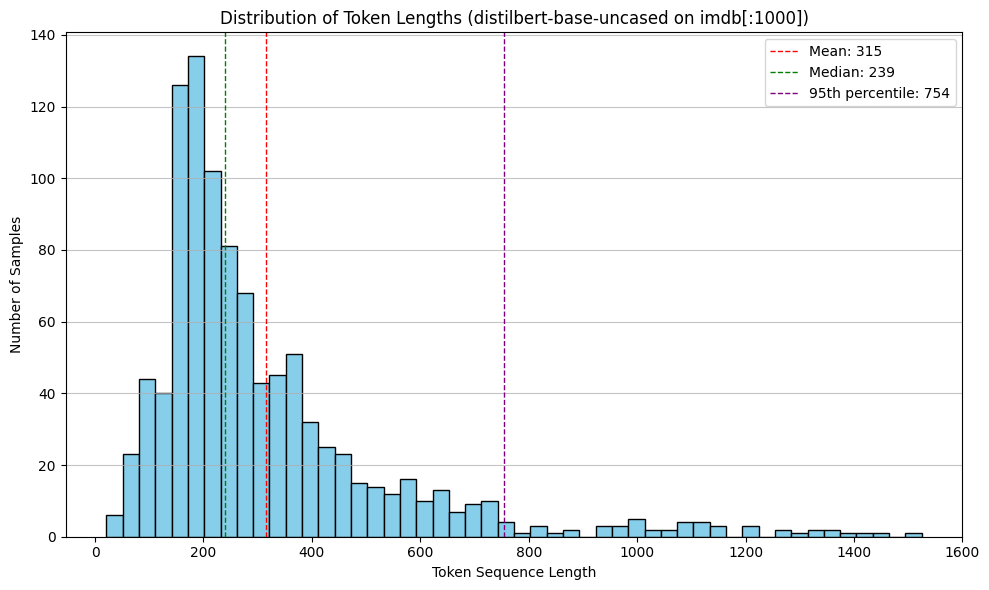

In [ ]:
# --- Prepare Data for Plotting ---
token_lengths = dataset_with_lengths["token_length"]

# --- Plot Histogram ---
print("\nGenerating histogram of token lengths...")
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black') # Adjust bins as needed
plt.title(f'Distribution of Token Lengths ({tokenizer_id} on {dataset_name}[:{len(dataset)}])')
plt.xlabel('Token Sequence Length')
plt.ylabel('Number of Samples')
plt.grid(axis='y', alpha=0.75)

# Add some descriptive statistics
mean_len = np.mean(token_lengths)
median_len = np.median(token_lengths)
max_len = np.max(token_lengths)
percentile_95 = np.percentile(token_lengths, 95)
plt.axvline(mean_len, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_len:.0f}')
plt.axvline(median_len, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_len:.0f}')
plt.axvline(percentile_95, color='purple', linestyle='dashed', linewidth=1, label=f'95th percentile: {percentile_95:.0f}')
plt.legend()

print(f"\nStatistics:")
print(f"- Mean length: {mean_len:.2f}")
print(f"- Median length: {median_len:.2f}")
print(f"- Max length: {max_len}")
print(f"- 95th percentile length: {percentile_95:.2f}")
print("\nWhy is this important? Helps choose appropriate 'max_length' for truncation/padding during training.")
print("Choosing a value around the 95th percentile often balances capturing most data vs. computational cost.")

# Show the plot
plt.tight_layout()
plt.show() # This will display the plot in a new window if run locally

# --- End of Recipe ---
